In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [14]:
df = pd.read_csv('../data/housing_preprocessed.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


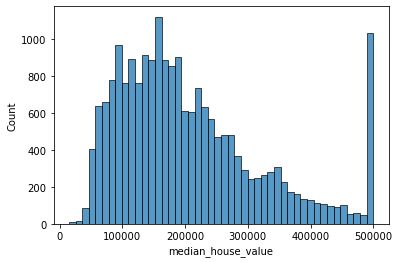

In [15]:
sns.histplot(df['median_house_value'])

Проверим данные на выбросы по правилу 3 сигм.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   <1H OCEAN           20640 non-null  int64  
 10  INLAND              20640 non-null  int64  
 11  ISLAND              20640 non-null  int64  
 12  NEAR BAY            20640 non-null  int64  
 13  NEAR OCEAN          20640 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 2.4 MB


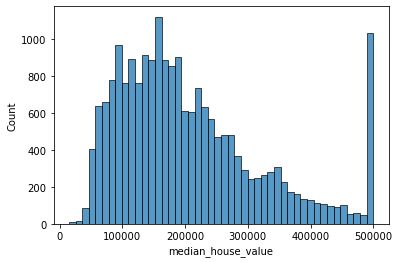

In [16]:
median = df['median_house_value'].median()
std = df['median_house_value'].std()
data = df[(df['median_house_value'] <= median + 3 * std) & (df['median_house_value'] >= median - 3 * std)]
sns.histplot(data['median_house_value'])
data.info()

Как оказалось все данные находятся в рамках 3 сигм, значит выбросов нет и можем приступать к делению выборки

In [17]:
X = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #разобьем выборку в соотношении 7/3, кроме того установим random_state=0 для повторения данной операции

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64


Приступим к обучению моделей и оценке их качества на метриках R^2, Mean Square Error(MSE), Root Mean Square Error(RMSE),  mean absolute error (MAE). И начнем с Линейной регрессии. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [26]:
param_grid = {'normalize': [True, False]}

estimator = LinearRegression()#Выбираем Регрессор
optimizer = GridSearchCV(estimator, param_grid)#создаем сетку для поиска гиперпараметров
optimizer.fit(X_train, y_train)#обучаем регрессор
predict = optimizer.predict(np.array(X_test))#предсказываем результат по тестовой выборке

print('Лучшие параметры', optimizer.best_params_)
print('R^2=', r2_score(y_test, predict))
print('MSE=', mean_squared_error(y_test, predict))
print('RMSE=', mean_squared_error(y_test, predict, squared=False))
print('MAE=', mean_absolute_error(y_test, predict))

Лучшие параметры {'normalize': False}
R^2= 0.6413588987000401
MSE= 4781535129.886362
RMSE= 69148.64517751857
MAE= 49656.93130855051


Оценим работу Регрессиии дерева решений https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [32]:
param_grid = {'max_depth': [5, 10, 15, None], 'min_samples_leaf': [1, 2, 5, 10, 20]}

estimator = DecisionTreeRegressor()#Выбираем Регрессор
optimizer = GridSearchCV(estimator, param_grid)#создаем сетку для поиска гиперпараметров
optimizer.fit(X_train, y_train)#обучаем регрессор
predict = optimizer.predict(np.array(X_test))#предсказываем результат по тестовой выборке

print('Лучшие параметры', optimizer.best_params_)
print('R^2=', r2_score(y_test, predict))
print('MSE=', mean_squared_error(y_test, predict))
print('RMSE=', mean_squared_error(y_test, predict, squared=False))
print('MAE=', mean_absolute_error(y_test, predict))

Лучшие параметры {'max_depth': None, 'min_samples_leaf': 20}
R^2= 0.7446188158113338
MSE= 3404835918.9282465
RMSE= 58350.97187646703
MAE= 38907.84574115645


Перейдем к регрессии LASSO https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [36]:
param_grid = {'normalize': [True, False], 'max_iter': [500, 1000, 1500, 2000, 3000]}

estimator = Lasso()#Выбираем Регрессор
optimizer = GridSearchCV(estimator, param_grid)#создаем сетку для поиска гиперпараметров
optimizer.fit(X_train, y_train)#обучаем регрессор
predict = optimizer.predict(np.array(X_test))#предсказываем результат по тестовой выборке

print('Лучшие параметры', optimizer.best_params_)
print('R^2=', r2_score(y_test, predict))
print('MSE=', mean_squared_error(y_test, predict))
print('RMSE=', mean_squared_error(y_test, predict, squared=False))
print('MAE=', mean_absolute_error(y_test, predict))

C:\Users\evgen\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4437455654723.379, tolerance: 15360483936.139502
  model = cd_fast.enet_coordinate_descent(
C:\Users\evgen\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4426167189327.754, tolerance: 15311960902.666803
  model = cd_fast.enet_coordinate_descent(
C:\Users\evgen\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4451275750581.746, tolerance: 15228887169.002113
  model = cd_fast.enet_coordinate_descent(
C:\Users\e

Проверим Гребневую регрессию https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [38]:
param_grid = {'normalize': [True, False], 'max_iter': [500, 1000, 1500, 2000, 3000]}

estimator = Ridge()#Выбираем Регрессор
optimizer = GridSearchCV(estimator, param_grid)#создаем сетку для поиска гиперпараметров
optimizer.fit(X_train, y_train)#обучаем регрессор
predict = optimizer.predict(np.array(X_test))#предсказываем результат по тестовой выборке

print('Лучшие параметры', optimizer.best_params_)
print('R^2=', r2_score(y_test, predict))
print('MSE=', mean_squared_error(y_test, predict))
print('RMSE=', mean_squared_error(y_test, predict, squared=False))
print('MAE=', mean_absolute_error(y_test, predict))

Лучшие параметры {'max_iter': 500, 'normalize': False}
R^2= 0.641181984344942
MSE= 4783893817.166814
RMSE= 69165.69826992867
MAE= 49665.447625041685


Elastic Net регрессор https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [40]:
param_grid = {'normalize': [True, False], 'max_iter': [500, 1000, 1500, 2000, 3000]}

estimator = ElasticNet()#Выбираем Регрессор
optimizer = GridSearchCV(estimator, param_grid)#создаем сетку для поиска гиперпараметров
optimizer.fit(X_train, y_train)#обучаем регрессор
predict = optimizer.predict(np.array(X_test))#предсказываем результат по тестовой выборке

print('Лучшие параметры', optimizer.best_params_)
print('R^2=', r2_score(y_test, predict))
print('MSE=', mean_squared_error(y_test, predict))
print('RMSE=', mean_squared_error(y_test, predict, squared=False))
print('MAE=', mean_absolute_error(y_test, predict))

Лучшие параметры {'max_iter': 500, 'normalize': False}
R^2= 0.6149437486183225
MSE= 5133711630.625231
RMSE= 71649.92414947298
MAE= 52521.078096435966


После обучения данных моделей можно сделать вывод, что на данной выборке данных лучше работает Elastic Net регрессор, а хуже всех решающее дерево.